#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# TODO
# vessel movement might be too big to do successful equation integration
# pipe inertia equation might be incorrect (check: M_t and Irho in cell 135)

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
# from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.integrate import odeint, ode, solve_ivp
# import tensorflow as tf
# import tensorflow_probability as tfp

In [3]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [5]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [6]:
node_N = 50

In [7]:
mi = [mp for i in range(node_N)] 

In [8]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [9]:
lx,ly,lz=L/2,B/2,H/2

In [10]:
vessel_mass=mn/L # mass over length of the vessel

In [11]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [12]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [13]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [14]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [15]:
vessel_inertia

60751987031.24999

In [16]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [17]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [18]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [19]:
E = 210e9

In [20]:
E*Ar/1e10

1.6991625880187402

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [28]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [29]:
rng = np.random.default_rng()

In [30]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [32]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.93134133, -0.36414261,  0.0018685 ],
       [-0.00341975, -0.01387718, -0.99989786],
       [ 0.36413135,  0.93123981, -0.01416967]])

In [33]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001720


In [34]:
Ret.shape

(50, 3, 3)

In [35]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [36]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [37]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000225


In [38]:
C1(dx,dy,dz,Ret)

array([[-2.91665112e+00,  1.28091043e-01,  2.10677252e-02,
         2.20996598e+00, -2.16486408e-01, -1.04079692e+00,
        -7.03313849e-01,  1.38815803e+00,  1.17508869e-01,
        -1.51124637e+00,  1.22461945e-01,  7.41645651e-01,
         3.73112253e+00,  2.91102703e-02,  4.43892954e-02,
        -4.40890481e-01,  5.94603456e-01, -7.85063281e-01,
        -1.02325239e+00,  2.21278075e-01,  6.30751922e-01,
        -1.47928586e+00,  4.36297880e-01,  9.53352326e-01,
         2.09790864e+00,  5.19894830e-01, -5.39427724e-01,
         1.77587819e+00,  2.41196108e-02, -6.91159957e-04,
         3.23633291e-01,  5.37677101e-03,  1.63523846e+00,
        -5.04849629e-01, -2.64039033e-02, -8.02613659e-01,
         3.69597630e+00, -1.91885928e-03, -2.37467312e-05,
        -1.85895244e-01, -1.99155468e+00,  3.68052506e-04,
         1.98334308e-01, -3.73320855e-01, -4.45009747e-01,
         5.49624299e-01,  1.50331622e+00, -3.18049883e-02,
         7.95685142e-02,  1.50736120e-01],
       [ 6.01

In [39]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [40]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.67387597e+04,  3.45261130e+03,  7.05571478e+03],
       [ 7.35118846e+02, -1.25931973e+04,  2.24670171e+04],
       [ 1.20908390e+02,  1.78165123e+03, -2.76717390e+03],
       [ 1.26830698e+04, -1.42801920e+03, -3.99698157e+03],
       [-1.24242284e+03, -7.06940966e+03, -1.52126582e+04],
       [-5.97316883e+03, -3.94124019e+03, -2.94864178e+02],
       [-4.03634205e+03, -2.71457325e+03,  5.35979737e+03],
       [ 7.96668603e+03,  3.12167050e+04, -3.94386883e+04],
       [ 6.74387388e+02, -2.23132733e+03,  2.70905274e+02],
       [-8.67309420e+03,  8.16657132e+03, -8.80030706e+03],
       [ 7.02813259e+02, -5.82550464e+03, -3.26646587e+04],
       [ 4.25632956e+03, -1.28713396e+03,  2.21601575e+03],
       [ 2.14130388e+04,  1.58125169e+03, -8.23884755e+01],
       [ 1.67064829e+02,  9.86986452e+03, -5.26558768e+03],
       [ 2.54751673e+02,  4.14989919e+02,  3.15483504e+03],
       [-2.53028543e+03,  4.03350060e+03,  5.38659861e+03],
       [ 3.41244941e+03,  2.08297602e+04

In [41]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000401


In [42]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [43]:
I=np.identity(3)

In [44]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000204


In [45]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [46]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [47]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [48]:
DR=np.diag(diag_DR) 

In [49]:
Ar

0.08091250419136858

In [50]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [51]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [52]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [53]:
def Re_b(Ret):
    return Ret

In [54]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000028


In [55]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [56]:
phi(x,y,z,Ret,None,None)

array([[-0.01837334,  1.17982829, -1.73732893],
       [-0.21350127,  1.49419912,  0.10169788],
       [ 0.11359309,  0.58755943,  0.1672082 ],
       [ 0.76321127, -2.04631623, -1.06633875],
       [-1.05151888,  0.6827091 , -0.82332306],
       [-0.82455577,  1.03231252, -1.15303593],
       [ 1.70776405,  0.58785674, -0.90075402],
       [ 0.71709618, -0.82597531,  0.96964818],
       [-0.02752519,  1.00919909,  0.91723541],
       [-0.28014344, -0.14074709, -1.21129614],
       [-2.1246226 , -0.64468992,  1.0461515 ],
       [ 0.64696237, -1.43503865,  1.81551713],
       [ 0.01074729, -1.04283344,  0.26564422],
       [-0.52173085, -1.73229734,  1.02942462],
       [-0.03951425,  1.02164385, -1.68211426],
       [-0.71697306, -0.57105624, -1.33647019],
       [ 2.03201357,  1.57365454, -1.66215356],
       [ 1.32105708, -1.55811055,  0.69062415],
       [-2.04623202, -1.12615731,  0.12202191],
       [-0.21525816,  2.43090192, -0.33860407],
       [-1.50800751,  0.54493119, -0.621

In [57]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000171


In [58]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [59]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [60]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000574


In [61]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))
    return A @ B

In [62]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000924


In [63]:
ωe(φ,θ,ψ,None,None,None).shape

(50, 3, 50)

In [64]:
# def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
# #     return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))
#     return B.T @A

In [65]:
# ωe(φ,θ,ψ,None,None,None).shape

In [66]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))
#     return A @ B

In [67]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001152


In [68]:
ωe(φ,θ,ψ,None,None,None).shape

(50, 3)

In [69]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [70]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [71]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-0.0261978 , -0.01245698, -0.00375325,  0.00871481, -0.01352123,
        -0.01961799, -0.01336935,  0.01612057, -0.00077524, -0.00964406,
         0.0151868 ,  0.02918564,  0.01172414,  0.02476984, -0.02428509,
        -0.00691976, -0.02904567,  0.02016117,  0.01117701, -0.02480351,
        -0.01047588,  0.007994  ,  0.0007621 ,  0.00899402, -0.0155972 ,
         0.00402657,  0.00502124, -0.00609393, -0.00815215, -0.00426404,
         0.00180198,  0.00543493, -0.00102955,  0.005182  , -0.00119695,
        -0.03142499,  0.01883339,  0.0216066 ,  0.0110731 ,  0.00535049,
         0.00522437, -0.01862904,  0.00529344, -0.0065673 ,  0.03050666,
        -0.0065054 , -0.02088217,  0.01177927, -0.01490308, -0.01291687],
       [ 0.17373264, -0.01209014, -0.01572001,  0.11356505,  0.07299948,
         0.10803314,  0.10544426, -0.09063875, -0.09205656,  0.11873692,
        -0.12372845, -0.17593325, -0.02649334, -0.107709  ,  0.16801675,
         0.12735672,  0.18455806, -0.0573048 , -0.

In [72]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001079


In [73]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [74]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [75]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.63884750e-06,  1.02499096e-07, -9.16639237e-07,
         1.28127417e-07, -1.52179391e-06, -1.96380544e-06,
         1.18973677e-06,  2.79876657e-08, -3.80627135e-07,
        -1.67989143e-06,  1.53363375e-06,  2.18915158e-06,
         1.70477286e-06,  5.96789083e-07,  3.30283268e-06,
         4.35096417e-07, -4.98632084e-06,  2.85666360e-06,
        -1.20126194e-06, -1.79809629e-07,  6.70631995e-07,
        -4.08496495e-07, -4.69449943e-07,  2.81275934e-06,
        -1.21257167e-06, -2.45487479e-06,  8.10573904e-07,
        -4.72677820e-07,  3.62320357e-06, -2.22482954e-06,
         1.07656486e-06,  1.07912996e-06, -8.12751389e-08,
        -1.62828337e-07, -1.01633458e-07, -4.04466869e-06,
        -8.71197134e-07, -8.99135628e-08,  1.68155943e-07,
         1.28864195e-06,  7.05191983e-07,  8.36622379e-07,
         6.31722829e-07, -7.33616171e-08, -3.45272369e-06,
        -1.21185180e-06,  2.55110317e-07,  1.04964866e-06,
        -1.15758297e-06,  5.60572355e-07],
       [-3.12

In [76]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [77]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.67387597e+04, -7.35118846e+02, -1.20908390e+02,
        -1.26830698e+04,  1.24242284e+03,  5.97316883e+03,
         4.03634205e+03, -7.96668603e+03, -6.74387388e+02,
         8.67309420e+03, -7.02813259e+02, -4.25632956e+03,
        -2.14130388e+04, -1.67064829e+02, -2.54751673e+02,
         2.53028543e+03, -3.41244941e+03,  4.50550481e+03,
         5.87248019e+03, -1.26992238e+03, -3.61990669e+03,
         8.48967175e+03, -2.50392834e+03, -5.47132136e+03,
        -1.20399689e+04, -2.98369408e+03,  3.09579401e+03,
        -1.01918252e+04, -1.38423265e+02,  3.96659045e+00,
        -1.85734244e+03, -3.08574713e+01, -9.38468902e+03,
         2.89734916e+03,  1.51532897e+02,  4.60622703e+03,
        -2.12113334e+04,  1.10123985e+01,  1.36283296e-01,
         1.06685911e+03,  1.14295999e+04, -2.11226582e+00,
        -1.13824732e+03,  2.14250105e+03,  2.55392604e+03,
        -3.15431250e+03, -8.62758280e+03,  1.82529907e+02,
        -4.56646403e+02, -8.65079709e+02],
       [-3.45

In [78]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001339


In [79]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-4.93187354e+01,  7.59807501e+05, -2.61651799e+05],
       [-6.98669417e-02, -9.86246945e+01,  8.04392021e+02],
       [ 1.88134358e+00,  1.69612899e+04, -3.59665798e+04],
       [-2.27856859e+02,  1.75086049e+06,  5.50751466e+05],
       [ 2.34997933e+02, -2.88473627e+06,  5.11046066e+05],
       [-3.06310866e+02,  2.99349692e+06,  1.00556805e+05],
       [-4.29275241e+02,  1.07867338e+06,  3.25760451e+06],
       [ 3.02272641e+02, -2.04799171e+06, -1.00531772e+06],
       [ 1.46770209e+02, -1.33542706e+06, -1.47107502e+05],
       [-2.09824976e+00,  2.55717509e+06, -2.53610916e+06],
       [ 2.65785300e+02,  3.32815269e+03, -2.68816391e+06],
       [ 1.65421278e-01, -2.25381657e+03,  5.82924390e+02],
       [-7.02415455e+01, -5.55068910e+05,  1.26464343e+06],
       [-6.17866847e+01, -1.33524366e+06,  1.95945077e+06],
       [-7.09263788e+01,  3.71404069e+05,  3.45041363e+05],
       [ 4.38571022e+02, -9.81663521e+05, -3.44852080e+06],
       [ 4.45269239e+01, -4.48418495e+05

In [80]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-9.66410632e+08, -2.62608546e+07, -7.60764200e+07],
       [-8.07843560e+08,  4.62676168e+02, -7.01100038e+04],
       [-8.00845771e+08, -3.67594172e+06, -1.77540871e+06],
       [-1.85482494e+08,  5.50567839e+07, -1.75104411e+08],
       [-8.58851099e+06,  5.11037563e+07,  2.88472777e+08],
       [ 1.28209862e+05,  1.00556932e+07, -2.99349679e+08],
       [-5.74163874e+08,  3.25703609e+08, -1.07924177e+08],
       [-1.36110213e+08, -1.00545247e+08,  2.04785697e+08],
       [ 4.76967929e+07, -1.47060282e+07,  1.33547428e+08],
       [-7.95180666e+07, -2.53618788e+08, -2.55725380e+08],
       [-6.92296785e+05, -2.68816460e+08, -3.32883803e+05],
       [-6.69355983e+08, -7.97381450e+03,  1.59118761e+05],
       [-1.53728854e+08,  1.26449124e+08,  5.54916726e+07],
       [-9.09670502e+06,  1.95944177e+08,  1.33523466e+08],
       [ 7.39389883e+08,  3.45773359e+07, -3.70672110e+07],
       [-7.02541693e+08, -3.44921632e+08,  9.80968040e+07],
       [-5.42523548e+07, -1.40211541e+05

In [81]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000339


In [82]:
Re_b(Ret).shape

(50, 3, 3)

In [83]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [84]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [85]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [86]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [87]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000659


In [88]:
d_me_

array([[-1.18764336e-04,  3.67528112e+02, -3.66347036e+02],
       [ 8.03975346e-07,  8.58480570e+02, -8.58532196e+02],
       [-1.37820830e-03,  8.48145855e+02, -8.34266836e+02],
       [ 3.06639036e-03,  1.03321316e+02, -1.34301756e+02],
       [ 2.62131645e-02, -3.11927933e+02,  4.71509268e+01],
       [ 6.79437421e-02, -6.94717781e+02,  8.41789722e+00],
       [ 2.81185121e-02, -1.86423769e+02, -9.76065036e+01],
       [-3.88317913e-02,  1.96123904e+01,  3.72646743e+02],
       [ 1.53440307e-02, -4.93368588e+01, -1.05658678e+02],
       [-3.95581670e-02, -1.23441065e+02,  5.23044946e+02],
       [-3.20366759e-02,  7.18442755e+00,  3.16434340e+02],
       [-4.75392286e-06,  7.57170445e+02, -7.57160793e+02],
       [-4.27108154e-02,  2.15010264e+02,  2.16423009e+02],
       [-4.06818940e-02, -1.04875928e+02,  5.15830219e+02],
       [-6.57328388e-03,  7.10793149e+02, -6.44429009e+02],
       [ 1.87289848e-02, -1.96505625e+02,  7.32436306e+00],
       [ 2.00601568e-02, -6.09146337e+01

In [89]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.67387597e+04, -7.35118846e+02, -1.20908390e+02,
        -1.26830698e+04,  1.24242284e+03,  5.97316883e+03,
         4.03634205e+03, -7.96668603e+03, -6.74387388e+02,
         8.67309420e+03, -7.02813259e+02, -4.25632956e+03,
        -2.14130388e+04, -1.67064829e+02, -2.54751673e+02,
         2.53028543e+03, -3.41244941e+03,  4.50550481e+03,
         5.87248019e+03, -1.26992238e+03, -3.61990669e+03,
         8.48967175e+03, -2.50392834e+03, -5.47132136e+03,
        -1.20399689e+04, -2.98369408e+03,  3.09579401e+03,
        -1.01918252e+04, -1.38423265e+02,  3.96659045e+00,
        -1.85734244e+03, -3.08574713e+01, -9.38468902e+03,
         2.89734916e+03,  1.51532897e+02,  4.60622703e+03,
        -2.12113334e+04,  1.10123985e+01,  1.36283296e-01,
         1.06685911e+03,  1.14295999e+04, -2.11226582e+00,
        -1.13824732e+03,  2.14250105e+03,  2.55392604e+03,
        -3.15431250e+03, -8.62758280e+03,  1.82529907e+02,
        -4.56646403e+02, -8.65079709e+02],
       [-3.45

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [99]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

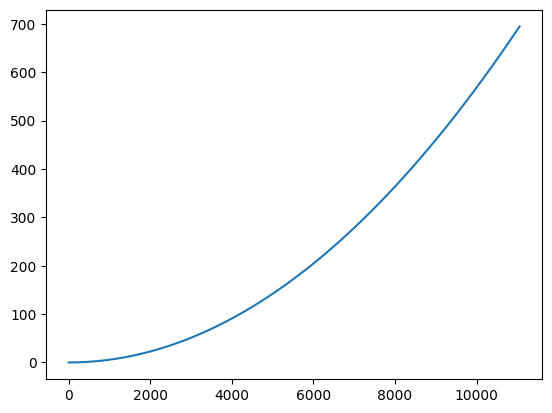

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [104]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [105]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [106]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [107]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [108]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_11041/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [109]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [110]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [111]:
q0=root

In [112]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

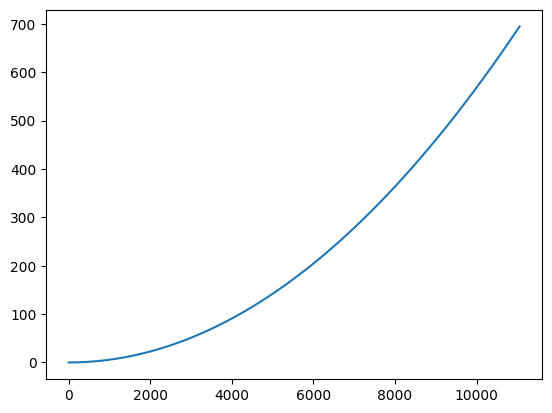

In [113]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [114]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [115]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [116]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [117]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [118]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [119]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [120]:
f

array([-1.00000000e+01, -8.37864663e-16,  2.00000000e+01,  3.94129174e-15,
        1.01675929e-15, -7.91033905e-16,  9.87206850e+00, -3.05675021e-02,
       -1.07838097e-01, -2.02690310e-03, -1.73997236e-01,  2.99464928e-02,
        9.02939690e-02, -3.92960434e-02, -1.98477415e+01,  3.86750341e-02,
        1.23200864e-01, -1.59047604e-03,  3.76375299e-02,  6.98635455e-02,
       -4.44204429e-02, -9.64417725e-02, -1.83601343e-03, -8.72036301e-02])

In [121]:
def PipeForce(X,Y,Z,vessel_force, coef=1, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    global_force=np.zeros(len(X)*6) 
    global_force[-6:]=coef*np.array(vessel_force)
    d,f=FEA_u(coord,elcon,bc_node,bc_val,global_force,E,G,A,Iy,Iz,J)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [122]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[67067.8422171882,
                 8866784.826883841, 
                 136429924.3688211, 
                 760945444.8381816, 
                 -5770549859.826721, 
                 374662591.12388337],1e-10)

In [123]:
fors

array([[-6.84410122e-06, -8.86777229e-04, -1.36430674e-02],
       [ 8.54015525e-10,  2.02240737e-08,  9.34551991e-09],
       [ 2.36286724e-09, -6.67786337e-09,  7.04319802e-09],
       [ 3.12411430e-09,  2.56297377e-08, -3.48443052e-09],
       [ 4.30736691e-09,  2.32831887e-09, -1.21783614e-08],
       [ 5.52972779e-09, -6.91948721e-09,  9.43964551e-09],
       [ 4.59840521e-09, -1.25380959e-08,  3.18259481e-08],
       [ 5.29689714e-09,  4.37427054e-08,  8.70204531e-09],
       [ 3.60887498e-09, -3.58642893e-09,  9.26775101e-10],
       [ 4.65661287e-10, -8.08735479e-09,  2.36614142e-08],
       [-4.42378223e-09, -1.87963991e-08,  1.41153578e-08],
       [-4.07453626e-09,  4.20153638e-09,  2.13804014e-08],
       [-8.84756446e-09, -3.92375910e-10,  6.90488378e-09],
       [-7.91624188e-09, -3.89059096e-09, -3.68163455e-09],
       [-9.31322575e-09, -3.62950203e-09,  2.91038305e-10],
       [-1.23400241e-08, -3.17361945e-09, -2.03435775e-08],
       [-1.55996531e-08,  1.03237170e-08

### Vessle Simulation

In [124]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [125]:
vehicle=semisub('DPcontrol',0,1,3.0,0,0) 

In [126]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [127]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

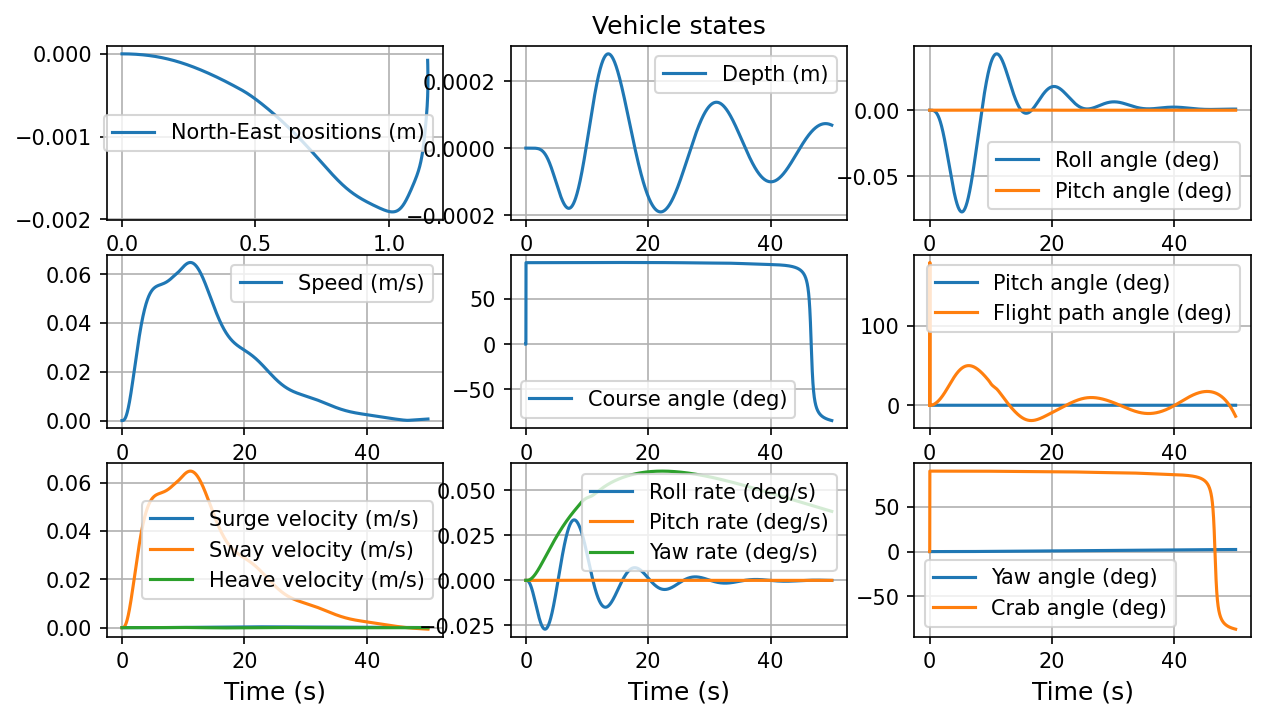

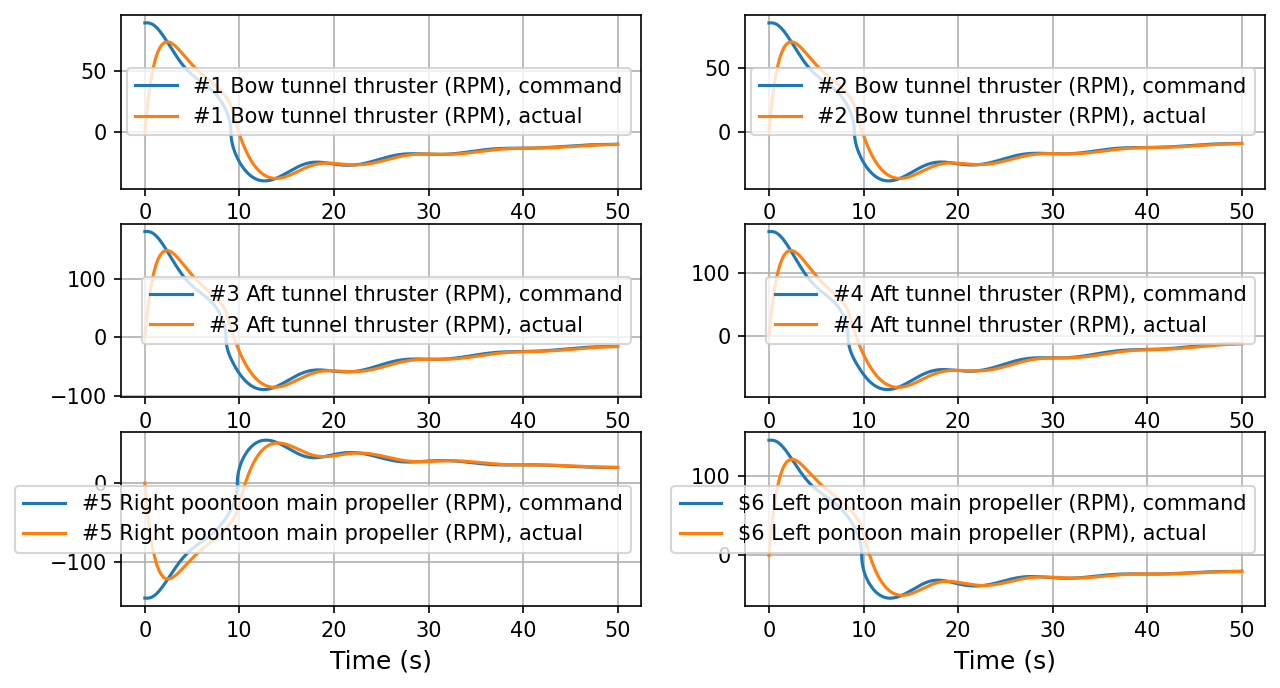

In [128]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [129]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

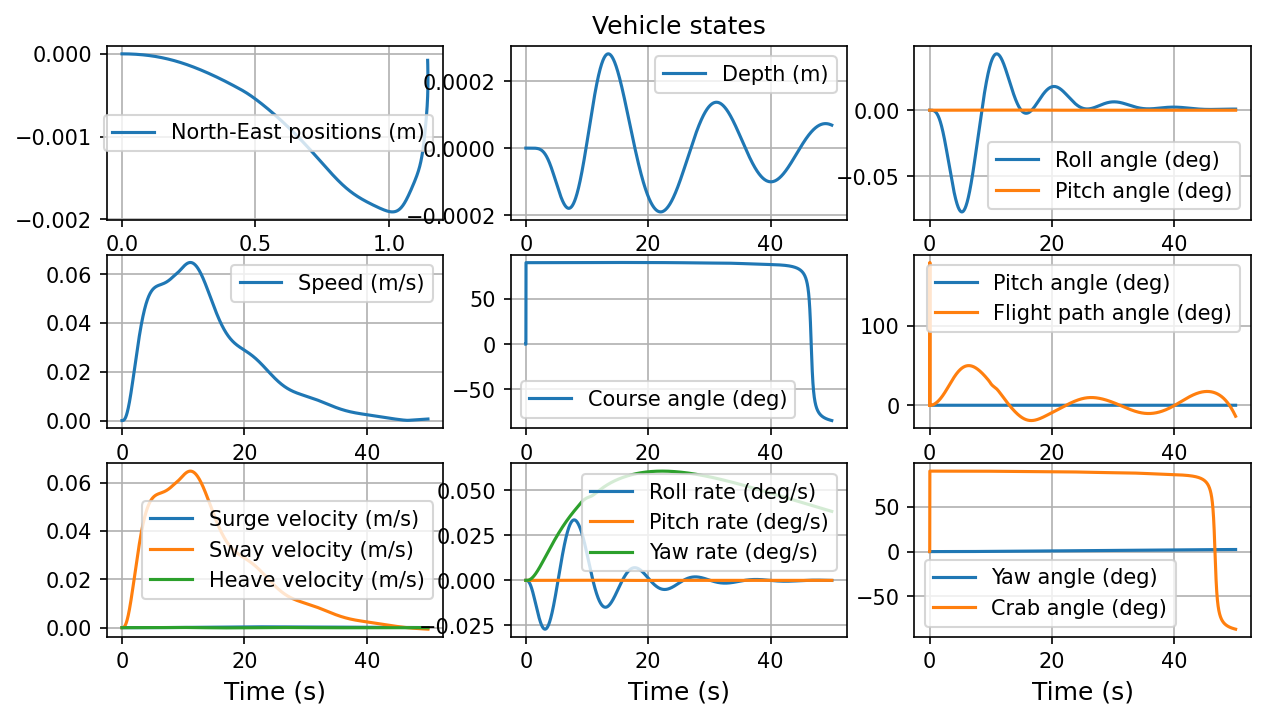

In [130]:
plotVehicleStates(simTime, simData, 3)

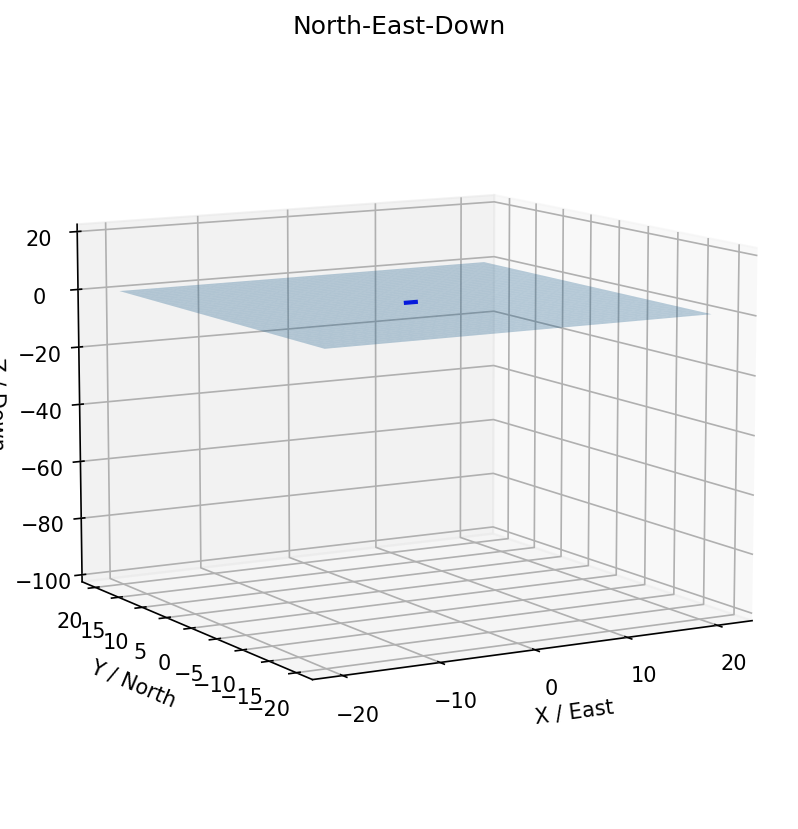

In [131]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [132]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [133]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [134]:
idx=1/0.01

In [135]:
idx

100.0

In [136]:
ssa(simData[:, 3][int(idx)])

-2.5508556559916684e-05

In [137]:
ssa(simData[:, 4][int(idx)])

9.124345723421357e-11

In [138]:
ssa(simData[:, 5][int(idx)])

6.513139855002237e-06

In [139]:
def inert(M, m, X):
#     sum_=M
    sum_=0
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [140]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [141]:
print(Irho_.shape)

(3, 3)


In [142]:
print(Irho.shape)

(50, 3, 3)


### Dynamics

In [143]:
def grayscott1d(t, Q): 
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    force_schedule=1
    
    fors, mom, angle = PipeForce(x,y,z,np.array(n_)/1000,force_schedule) # divided by 1000 because FE model is in kN 
    
    φ,θ,ψ=angle.T

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()


    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [144]:
tspan = (0., 0.1)
# dt = 0.5
# t=np.arange(0,50,dt)
# t_init, t0, t1 = 0., 0., 50.

In [145]:
# !pip3 install --upgrade scipy

In [146]:
startTime1 = datetime.now()
# us = odeint(grayscott1d,t, q0)

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )

# us = tfp.math.ode.BDF().solve(grayscott1d, t_init, q0,
#                                    solution_times=[t0, t1])

print(datetime.now() - startTime1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_11041/3049520153.py", line 4, in <module>
    us=solve_ivp(grayscott1d,  tspan, q0,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/ivp.py", line 650, in solve_ivp
    message = solver.step()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/base.py", line 197, in step
    success, message = self._step_impl()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py", line 144, in _step_impl
    y_new, f_new = rk_step(self.fun, t, y, self.f, h, self.A,
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/in

In [ ]:
# key takeaway: it needed FEM model. Space frame element approximation is crude, but seems to work.
# The only parameter to tune is force_schedule

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()